<p float="left">
<img src="images/dask_horizontal.svg" width="45%" alt="Dask logo\"> <img src="images/numba_horizontal.svg" vspace="50" width="45%" alt="Numba logo\">
</p>

<h1><center>Using Dask (and Numba) to Explore Chicago Taxi Trips</center></h1>

## Anirrudh Krishnan
### Software Engineer, Quansight
#### PyLadies Chicago Meetup - August 2019


In [1]:
import os, sys
import numpy as np
import dask
from datetime import datetime 

## What is Dask?

* Dask is an open source library for parallel computing in Python - helping the language scale.

## Why Dask?

* Large Dataset (49.63 GB) - Doesn't fit in memory!
* Scalable on local machine - and clusters
* Familiar API (Similar to NumPy, Pandas, SciPy, etc,), and easily implementable

<h1 align="center">Dask Components</h1>

<img src="images/dask-components.svg" hspace="50px" width="60%" alt="Dask logo\">

## Dask Schdeuler

Dask has a scheduler which is deployed in a number of ways - and can easily scale to a cluster. For the purpose of showing the
speed of Dask, we will be executing on a single-machine, but will utilize the scheduler's ability so spread across processes and threads
to speed up the process.

Furthermore, there is a Dask Web UI we can use to monitor jobs.

The Dask Distributed Client import assumes that we are running a Distributed Scheduler. This can be deployed onto several machines as well, but for this demo, we will
run the distributed client across once machine.

There _is_ a Single-Machine Scheduler, but the Distributed Client is strongly reccommended on a single machine. 

GIL-Safety also is taken into account here; and there can be a `processes=False` arg passed to the Client.

In [2]:
from dask.distributed import Client 
client = Client() # Dask Scheduler Started at port 8787

## Preliminary Cleansing

In the current day and age we live in, `.csv` files are _everywhere_. While these file have certain advantages over other formats (i.e. xlsx), these files have constrains.
The most glaring constraint: We have to read an entire file to extrapolate any data from it.

The answer to this problem are `.parquet` files. While the conversion _did_ take some time, the performance tradeoff was worth it.

We also need to be cautious of using df.set_index. This is an incredibly costly operation that should only be run when absolutley needed.

```Python
df = dd.read_csv('taxi_trips.csv')
df.trip_start_timestamp = df.trip_start_timestamp.astype(dtype='datetime64[ns]')
df = df[(df.fare != 0) & (df.fare != 9999.99)]
df = df.set_index('trip_start_timestamp', shuffle='tasks')
df.to_parquet('taxi_trips.parq')
```

I did the above as a small pre-processing step. On my local machine, the total time took ~25 minutes. Not bad for 2.7 Billion Rows!

For future reference, I profiled the code.

In [3]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
from IPython.display import IFrame
IFrame(src='./profile.html', width="100%", height=350)

Loading BokehJS ...

## Dask Dataframe: Stacked Pandas Dataframes

While thinking about Dask Dataframes, we should think about them as a collection of Pandas dataframes. Dask dataframes can come from a variety of formats, as well as write to a variety of formats.

<img src="images/dask-dataframe.svg" width="400px">


In [4]:
import dask.dataframe as dd
df = dd.read_parquet("taxi_trips.parq")

In [5]:
sz = df.size.compute()

In [6]:
df.npartitions

776

In [7]:
df.columns, sz

(Index(['dropoff_centroid_longitude', 'tax', 'fare', 'taxi_id', 'payment_type',
        'dropoff_community_area', 'trip_total', 'tips', 'tolls', 'trip_id',
        'trip_miles', 'pickup_centroid_location', 'trip_end_timestamp',
        'extras', 'pickup_census_tract', 'pickup_centroid_latitude',
        'dropoff_centroid_location', 'company', 'dropoff_census_tract',
        'pickup_centroid_longitude', 'trip_seconds',
        'dropoff_centroid_latitude', 'pickup_community_area'],
       dtype='object'), 2590651253)

### Basic Data Cleansing

So I cheated, and I saw some outliers while running the computation. I made the decision to drop these row based on the fact that
they make no sense: while the trip might have taken place, in terms of the monetary calculation, it does not make sense when the
max is 9999.99 and the min is 0.00 for the fare of the taxi - we can (probably) make the assumption that nobody paid nothing and that nobody paid
9999.99 for a ride...



```Python
import dask.diagnostics as ddiag
def gen_vars(df, col):
    tmean = df[col].mean()
    tmax = df[col].max()
    tmin = df[col].min()
    tsum = df[col].sum()
    return [tsum, tmean, tmax, tmin]

def general_statistics():
        stats = {}
        for year in range(2013, 2018):
            tmp = df.loc[f'{year}-01-01':f'{year}-12-31']
            tmp = client.persist(tmp)
            fares = gen_vars(tmp,'fare')
            taxes = gen_vars(tmp, 'tax')
            tips = gen_vars(tmp, 'tips')
            tolls = gen_vars(tmp, 'tolls')
            ## Nothing actually executes until compute is called 
            stats[f'{year}'] = [[i.compute() for i in fares], [i.compute() for i in taxes], \
                                [for i in tips i.compute()], [i.compute() for i in tolls]]
        return stats

with ddiag.Profiler() as prof:
    stats = general_statistics()
prof.results()
prof.visualize()
stats
```

Output:
```JSON
{'2013': [[334725854.08000004, 12.517548422379694, 9900.21, 0.01],
  [6.33, 3.7541406748272475e-07, 1.0, 0.0],
  [25938100.89, 0.9699920992584738, 444.74, 0.0],
  [406944.62, 0.015218271681097696, 8099.94, 0.0]],
 '2014': [[381046114.84000003, 12.300617398186134, 9929.39, 0.01],
  [47.900000000000006, 2.344559269112282e-06, 9.05, 0.0],
  [35958032.760000005, 1.160767650282764, 500.0, 0.0],
  [206475.48, 0.006665271689368298, 2415.52, 0.0]],
 '2015': [[348887915.13, 12.746769514750685, 9966.66, 0.01],
  [409.9, 2.3139617644774183e-05, 70.71, 0.0],
  [38402760.77, 1.4030613243880965, 596.85, 0.0],
  [182049.61000000002, 0.006651260528916824, 2103.75, 0.0]],
 '2016': [[276114130.7, 13.901143445208735, 9999.0, 0.01],
  [83.41, 6.823152253803921e-06, 60.0, 0.0],
  [32691801.329999994, 1.645889758044881, 496.5, 0.0],
  [64796.23, 0.003262207861854778, 999.99, 0.0]],
 '2017': [[103907969.46000001, 13.522256846435123, 9600.58, 0.01],
  [33.0, 7.83437467208394e-06, 32.5, 0.0],
  [12708106.55, 1.6537930795300186, 800.0, 0.0],
  [36309.72, 0.004725232938472074, 999.99, 0.0]]}
```

In [9]:
def gen_column_delayed(col, year):
    tsum = df[col].loc[f'{year}-01-01':f'{year}-12-31'].sum()
    tmean = df[col].loc[f'{year}-01-01':f'{year}-12-31'].mean()
    tmax = df[col].loc[f'{year}-01-01':f'{year}-12-31'].max()
    tmin = df[col].loc[f'{year}-01-01':f'{year}-12-31'].min()
    return {f'{col}': {'Sum':tsum, 'Mean':tmean, 'Min':tmin, 'Max':tmax}}

def gen_yearly(year):
    fare_lazy = gen_column_delayed('fare', year)
    taxes_lazy = gen_column_delayed('tax', year)
    tips_lazy = gen_column_delayed('tips', year)
    tolls_lazy = gen_column_delayed('tolls', year)
    data = {**fare_lazy, **taxes_lazy, **tips_lazy, **tolls_lazy}
    return {f'{year}': data}

stat = {**gen_yearly(year='2013'), **gen_yearly(year='2014'), **gen_yearly(year='2015'), **gen_yearly(year='2016'), **gen_yearly(year='2017')}
stat.visualize()

In [ ]:
from dask.diagnostics import ResourceProfiler
with ResourceProfiler() as prof:
    labels = ['fare', 'tax', 'tips', 'tolls']
    for year in range(2013,2018):
        for label in labels:
            data = stat[f'{year}'][f'{label}']
            for k,v in data.items():
                data[k] = [v.compute()][0]

In [11]:
stat

{'2013': {'fare': {'Sum': 334725854.08000004,
   'Mean': 12.517548422379694,
   'Min': 0.01,
   'Max': 9900.21},
  'tax': {'Sum': 6.33, 'Mean': 3.7541406748272475e-07, 'Min': 0.0, 'Max': 1.0},
  'tips': {'Sum': 25938100.89,
   'Mean': 0.9699920992584738,
   'Min': 0.0,
   'Max': 444.74},
  'tolls': {'Sum': 406944.62,
   'Mean': 0.015218271681097696,
   'Min': 0.0,
   'Max': 8099.94}},
 '2014': {'fare': {'Sum': 381046114.84000003,
   'Mean': 12.300617398186134,
   'Min': 0.01,
   'Max': 9929.39},
  'tax': {'Sum': 47.900000000000006,
   'Mean': 2.344559269112282e-06,
   'Min': 0.0,
   'Max': 9.05},
  'tips': {'Sum': 35958032.760000005,
   'Mean': 1.160767650282764,
   'Min': 0.0,
   'Max': 500.0},
  'tolls': {'Sum': 206475.48,
   'Mean': 0.006665271689368298,
   'Min': 0.0,
   'Max': 2415.52}},
 '2015': {'fare': {'Sum': 348887915.13,
   'Mean': 12.746769514750685,
   'Min': 0.01,
   'Max': 9966.66},
  'tax': {'Sum': 409.9,
   'Mean': 2.3139617644774183e-05,
   'Min': 0.0,
   'Max': 70.71

In [12]:
prof.visualize(save=True)

Figure(id='35940', ...)

## Back to Pandas!

In [174]:
import pandas as pd

def flatten_df():
    dfs = []
    for k,v in stat.items():
        df = pd.DataFrame.from_dict(stat[k])
        df = df.T
        df['year'] = k
        dfs.append(df)
    return dfs

def extract_data(dict_val):
    return dict_val['Sum']

lambda x: "{0:.2f}".format(round(x,2)) # Thank you StackOverflow for reminding me [https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points]

dfv = pd.DataFrame.from_dict(stat)
dfv = dfv.T.applymap(extract_data)
dfv = dfv.applymap(lambda x: "{0:.2f}".format(round(x,2)))
dfv

fare     tax         tips      tolls
2013  334725854.08    6.33  25938100.89  406944.62
2014  381046114.84   47.90  35958032.76  206475.48
2015  348887915.13  409.90  38402760.77  182049.61
2016  276114130.70   83.41  32691801.33   64796.23
2017  103907969.46   33.00  12708106.55   36309.72

In [183]:
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge

money_tp = list(dfv)
years = list(dfv.T)

data = dfv.T.to_dict('list')
data['monetary_count'] = money_tp

source = ColumnDataSource(data=data)

p = figure(x_range=money_tp, y_range=(0, 500000000), plot_height=500, title="Monetary Trends Over Years",
           toolbar_location=None, tools="")

p.vbar(x=dodge('monetary_count', -0.25, range=p.x_range), top='2013', width=0.2, source=source,
       color="#c9d9d3", legend=value("2013"))

p.vbar(x=dodge('monetary_count',  0.0,  range=p.x_range), top='2014', width=0.2, source=source,
       color="#718dbf", legend=value("2014"))

p.vbar(x=dodge('monetary_count',  0.25, range=p.x_range), top='2015', width=0.2, source=source,
       color="#e84d60", legend=value("2015"))

p.vbar(x=dodge('monetary_count',  0.50, range=p.x_range), top='2016', width=0.2, source=source,
       color="#e84d60", legend=value("2016"))

p.vbar(x=dodge('monetary_count',  0.75, range=p.x_range), top='2017', width=0.2, source=source,
       color="#e84d60", legend=value("2017"))

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
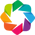

:DynamicMap   []
   :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .RGB.I  :RGB   [pickup_centroid_longitude,pickup_centroid_latitude]   (R,G,B,A)

In [197]:
import holoviews as hv
import geoviews as gv
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'
tile_opts  = dict(width=1000,height=600,xaxis=None,yaxis=None,bgcolor='black',show_grid=False)
map_tiles  = gv.WMTS(url).opts(style=dict(alpha=0.5), plot=tile_opts)
points     = hv.Points(df, ['pickup_centroid_longitude', 'pickup_centroid_latitude'])
taxi_trips = datashade(points, x_sampling=1, y_sampling=1, cmap=fire, width=1000, height=600)

map_tiles * taxi_trips



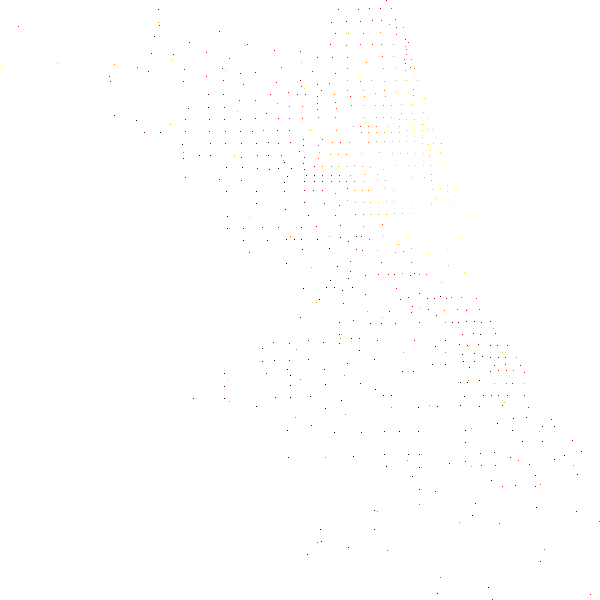

In [202]:
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf
agg = ds.Canvas().points(df.loc[f'2014-01-01':f'2014-12-31'], 'dropoff_centroid_longitude', 'dropoff_centroid_latitude')
tf.set_background(tf.shade(agg, cmap=fire),"white")

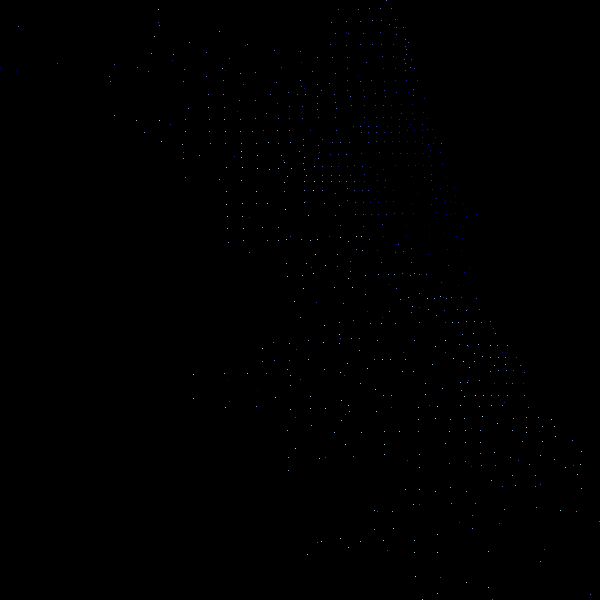

In [201]:
tf.set_background(tf.shade(agg),"black")

In [203]:
# from bokeh.tile_providers import STAMEN_TERRAIN

# Chicago = ((-8242000,-8210000), (4965000,4990000))
# plot_width  = int(750)
# plot_height = int(plot_width//1.2)

# def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
#     p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
#         x_range=x_range, y_range=y_range, outline_line_color=None,
#         min_border=0, min_border_left=0, min_border_right=0,
#         min_border_top=0, min_border_bottom=0, **plot_args)

#     p.axis.visible = False
#     p.xgrid.grid_line_color = None
#     p.ygrid.grid_line_color = None

#     p.add_tools(BoxZoomTool(match_aspect=True))

#     return p

# options = dict(line_color=None, fill_color='blue', size=5)
# samples = df.sample(frac=1000)
# p = base_plot()
# p.add_tile(STAMEN_TERRAIN)
# p.circle(x=samples['pickup_centroid_latitude'], y=samples['pickup_centroid_longitude'], **options)
# show(p)

# Using Dask Array to Compute Neighborhood Frequencies

The Dask Array is a completly different object than the Dask Dataframe. We will use the array object in conjunction with the low level futures API in order to understand how
these processes work. 

##### TODO WRITE MORE ABOUT BLOCKED ALGORITHIMS ?

In [231]:
df = dd.read_parquet("taxi_trips.parq")
dft = df[['trip_miles']]

In [232]:
arr = dft.to_dask_array(lengths=True)

In [233]:
arr = arr.rechunk('auto')

In [234]:
arr

dask.array<rechunk-merge, shape=(112637011, 1), dtype=float64, chunksize=(16777216, 1)>

In [235]:
arr.visualize(filename='transpose.svg')

In [237]:
type(arr)

dask.array.core.Array

In [242]:
mean = dask.array.nansum(arr)

In [241]:
def convert_to_km(arr):
    return numpy.multiply(arr * 0.621371).compute()

In [243]:
big_future = client.scatter(arr)
future = clent.submit(convert_to_km, big_future)

/anaconda3/lib/python3.7/site-packages/distributed/worker.py:3165: UserWarning: Large object of size 2.07 MB detected in task graph: 
  (dask.array<rechunk-merge, shape=(112637011, 1), d ... 16777216, 1)>,)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [244]:
future

<Future: status: finished, type: Array, key: convert_to_km-d87dea6506186851a632c44c4cece670>

In [247]:
future.result()

array([[1.4291533],
       [0.621371 ],
       [0.       ],
       ...,
       [0.3728226],
       [0.3106855],
       [0.8699194]])

In [249]:
mean.compute()

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
